In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
sc.settings.verbosity = 1

#sc.logging.print_versions()

import os 
import sys
import gc
import importlib

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
sns.set_style('white', {'axes.grid' : False})


def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

In [2]:
def gem2adata(in_put, binsize, in_type='file', sep='\t'):
    import scipy.sparse as sps
    if in_type == 'file':
        df = pd.read_csv(in_put, comment='#', sep=sep)
    if in_type == 'df':
        df = in_put.copy()
        
    df['x'] = df['x'].apply(lambda x: int(x/binsize)*binsize)
    df['y'] = df['y'].apply(lambda x: int(x/binsize)*binsize)
    
    if 'geneName' in df.columns:
        df['index'] = df['x'].apply(str) + '_' + df['y'].apply(str) + '@' + df['geneName']   
    else:
        df['index'] = df['x'].apply(str) + '_' + df['y'].apply(str) + '@' + df['geneID']
        
    try:
        df = df[['index', 'MIDCounts']]
    except:
        df = df[['index', 'MIDCount']]
    
    df.columns = ['index', 'MIDCounts']

    df = df.groupby('index').sum()

    df[['index', 'geneID']] = [x.split('@') for x in df.index]
    index = df['index'].unique()
    idict = dict(zip(index, range(len(index))))
    geneID = df['geneID'].unique()
    gdict = dict(zip(geneID, range(len(geneID))))

    df['index'] = df['index'].apply(lambda x: idict[x])
    df['geneID'] = df['geneID'].apply(lambda x: gdict[x])

    csr_matrix = sps.csr_matrix((df['MIDCounts'].values, (df['index'].values, df['geneID'].values)), shape=(len(index), len(geneID)))
    adata = sc.AnnData(csr_matrix)
    adata.obs[['x', 'y']] = [x.split('_') for x in index]
    adata.obs[['x', 'y']] = adata.obs[['x', 'y']].applymap(int)
    adata.obs_names = ['DNB_' + x for x in index]
    adata.var_names = geneID
    adata.obsm['spatial'] = adata.obs[['x', 'y']].values
    return adata

def reloc(adata, arrange='v', cat=None):
    loc = adata.obs[['x','y']].astype(float).copy()
    adata.obs['sample'] = adata.obs['sample'].astype('category')
    if cat is not None:
        adata.obs['sample'] = pd.Categorical(adata.obs['sample'], categories=cat)
    for slide in adata.obs['sample'].cat.categories:
        tmp = loc.loc[adata.obs_names[adata.obs['sample'] == slide], :].copy()
        x_range, y_range = tmp.max() - tmp.min()
        # if (arrange=='v') & (x_range >= y_range):
        #     tmp[['x', 'y']] = tmp[['y', 'x']].to_numpy()
        # if (arrange=='h') & (x_range < y_range):
        #     tmp[['x', 'y']] = tmp[['y', 'x']].to_numpy()
            
        x_mean = int(tmp['x'].mean())
        y_mean = int(tmp['y'].mean())
        loc.loc[tmp.index, 'x'] = tmp['x'].values - x_mean
        loc.loc[tmp.index, 'y'] = tmp['y'].values - y_mean

    #adata.obsm['X_umap_bak'] = adata.obsm['X_umap']
    adata.obsm['X_umap'] = loc.to_numpy()

    x_edge = 0
    for sample in adata.obs['sample'].cat.categories:
        tmp = adata[adata.obs['sample']==sample, :]
        r = (tmp.obsm['X_umap'][:, 0].max() - tmp.obsm['X_umap'][:, 0].min())/2
        loc.loc[tmp.obs_names, 'x'] = loc.loc[tmp.obs_names, 'x'] + x_edge + r + 1000
        x_edge = loc.loc[tmp.obs_names, 'x'].max()
    loc = loc - loc.min()
    adata.obsm['X_umap'] = loc.to_numpy()
    adata.obsm['spatial'] = loc.to_numpy()

def sc_qc(adata, min_genes=0, max_genes=0, mt_pct=0, min_cells=0, sc_cal=True, sc_filter=True):
    if sc_cal:
        adata.var['mt'] = adata.var_names.str.startswith('mt-')
        adata.var['rp'] = adata.var_names.str.startswith('Rpl') | adata.var_names.str.startswith('Rps')
        if adata.var['mt'].sum() == 0:
            adata.var['mt'] = adata.var_names.str.startswith('MT-')
            adata.var['rp'] = adata.var_names.str.startswith('RPL') | adata.var_names.str.startswith('RPS')
        sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        sc.pp.calculate_qc_metrics(adata, qc_vars=['rp'], percent_top=None, log1p=False, inplace=True)
        
    if sc_filter:
        if min_genes > 0:
            sc.pp.filter_cells(adata, min_genes=min_genes)
        if max_genes > 0:
            sc.pp.filter_cells(adata, max_genes=max_genes)
        
        if mt_pct > 0:    
            adata = adata[adata.obs.pct_counts_mt <= mt_pct, :]
        if min_cells > 0:
            sc.pp.filter_genes(adata, min_cells=min_cells)
    
    return adata

def del_mt_rp(adata):
    var_names = adata.var_names[~(adata.var['mt'] | adata.var['rp'])]
    var_names = var_names[~var_names.isin([x for x in var_names if '.' in x])]
    return adata[:, var_names]

def gene2im(adata, gene_list, bin_size, layer=None, save=None):
    minx = adata.obs['x'].min()
    miny = adata.obs['y'].min()
    x_count = int((adata.obs['x'].max() - adata.obs['x'].min())/bin_size) + 1
    y_count = int((adata.obs['y'].max() - adata.obs['y'].min())/bin_size) + 1

    xs = ((adata.obs['x'] - adata.obs['x'].min())/bin_size)
    ys = ((adata.obs['y'] - adata.obs['y'].min())/bin_size)
    
    if layer:
        data = adata[:, gene_list].layers[layer].sum(axis=1)
    else:
        data = adata[:, gene_list].X.sum(axis=1)
    
    data = np.array(data)[:, 0]
    vmax = np.quantile(data, 0.99)
    
    import scipy.sparse as sps
    im = sps.coo_array((data, (xs, ys)), shape=(x_count, y_count), dtype=float)
    
    plt.imshow(im.A, vmax=vmax)
    plt.grid(False)
    plt.show()
    
    if save:
        import cv2
        cv2.imwrite(save, im.A.astype(np.uint8))

# tissue O

In [3]:
A3 = gem2adata('gem/H01203A3.lasso.bin1.tissue.gem.gz', binsize=50)
C3 = gem2adata('gem/H01203C3.lasso.bin1.tisse.gem.gz', binsize=50)

In [5]:
A3.obs['sample'] = 'H01203A3'
A3.obs_names = ['H01203A3@' + x for x in A3.obs_names]
C3.obs['sample'] = 'H01203C3'
C3.obs_names = ['H01203C3@' + x for x in C3.obs_names]

In [6]:
sc_qc(A3, sc_filter=False)
sc_qc(C3, sc_filter=False)

AnnData object with n_obs × n_vars = 143653 × 40776
    obs: 'x', 'y', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'

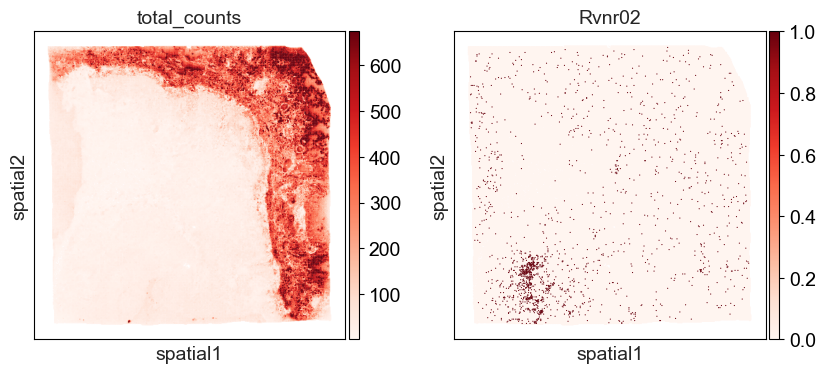

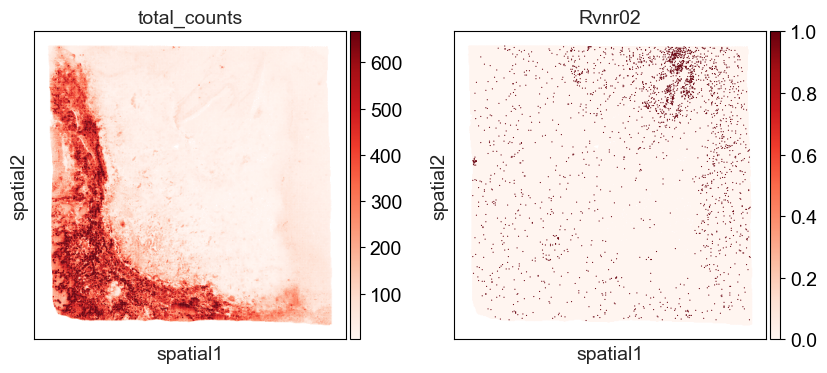

In [9]:
sc.pl.spatial(A3, color=['total_counts', 'Rvnr02'], spot_size=80, vmax='p99', cmap='Reds')
sc.pl.spatial(C3, color=['total_counts', 'Rvnr02'], spot_size=80, vmax='p99', cmap='Reds')

In [10]:
# C3.obsm['spatial'] = C3.obsm['spatial'][:, [1,0]]
C3.obsm['spatial'][:, 1] = -C3.obsm['spatial'][:, 1]
C3.obsm['spatial'][:, 0] = -C3.obsm['spatial'][:, 0]

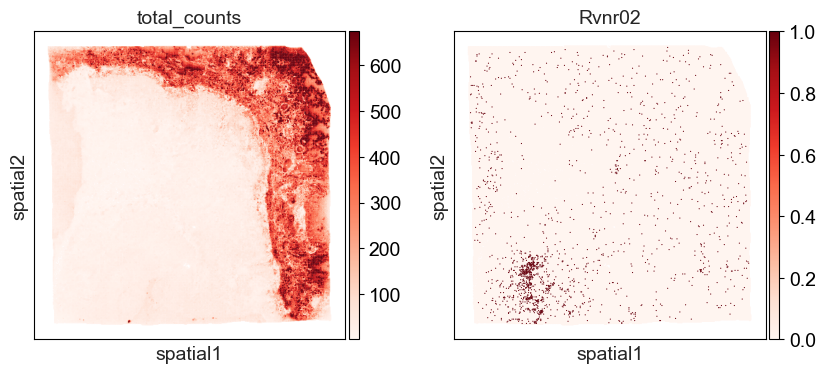

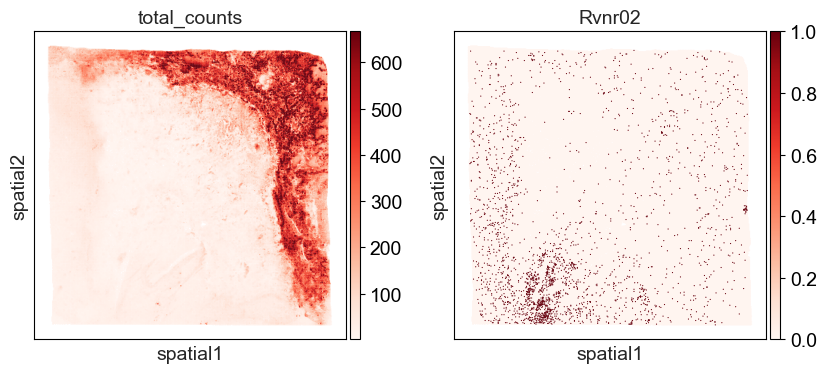

In [11]:
sc.pl.spatial(A3, color=['total_counts', 'Rvnr02'], spot_size=80, vmax='p99', cmap='Reds')
sc.pl.spatial(C3, color=['total_counts', 'Rvnr02'], spot_size=80, vmax='p99', cmap='Reds')

In [12]:
tissue_o = sc.concat([A3, C3], join='outer')

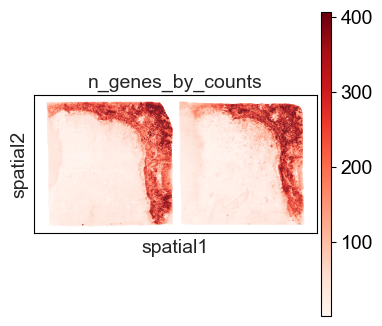

In [13]:
tissue_o.obs[['x', 'y']] = tissue_o.obsm['spatial'].copy()
reloc(tissue_o, arrange='v')
sc.pl.spatial(tissue_o, color=['n_genes_by_counts'], cmap='Reds', vmax='p99', ncols=1, spot_size=80)

In [15]:
tissue_o.write('tissue_o_raw.h5ad')

In [16]:
tbgenes = [x for x in tissue_o.var_names if x.startswith('Rv') or x.startswith('RV')]
tissue_o.obs['tb_counts'] = tissue_o[:, tbgenes].X.sum(axis=1).A[:,0]

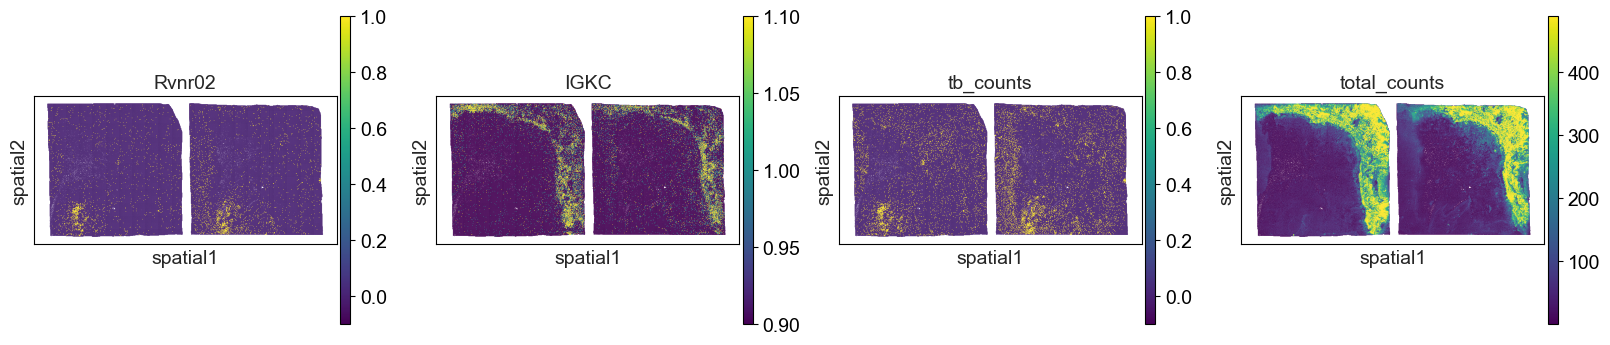

In [18]:
sc.pl.spatial(tissue_o, spot_size=80, color=['Rvnr02', 'IGKC', 'tb_counts', 'total_counts' ], vmax='p95', vmin=1, cmap='viridis', save='tissue_o_tb_count.pdf')

/home/lee/miniconda3/envs/rapids/lib/python3.10/site-packages/scipy/sparse/_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


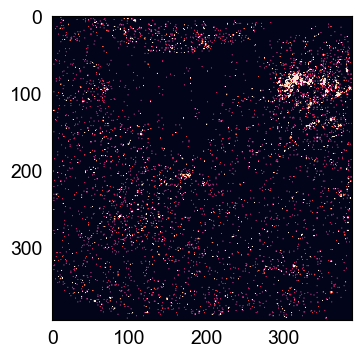

In [19]:
gene2im(tissue_o[tissue_o.obs['sample']=='H01203A3'], tbgenes, bin_size=50, save='H01203A3_bin50.tif')

/home/lee/miniconda3/envs/rapids/lib/python3.10/site-packages/scipy/sparse/_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


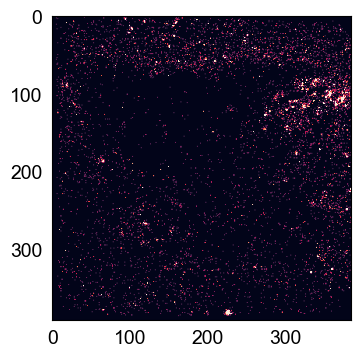

In [20]:
gene2im(tissue_o[tissue_o.obs['sample']=='H01203C3'], tbgenes, bin_size=50, save='H01203C3_bin50.tif')

# tissue N

In [23]:
c1 = gem2adata('gem/H01203C1.lasso.bin1.tissue.gem.gz', binsize=50)
d5 = gem2adata('gem/H01203D5.lasso.bin1.tisse.gem.gz', binsize=50)

In [26]:
c1.obs['sample'] = 'H01203C1'
c1.obs_names = ['H01203C1@' + x for x in c1.obs_names]
d5.obs['sample'] = 'H01203D5'
d5.obs_names = ['H01203D5@' + x for x in d5.obs_names]

In [25]:
sc_qc(c1, sc_filter=False)
sc_qc(d5, sc_filter=False)

AnnData object with n_obs × n_vars = 135299 × 40655
    obs: 'x', 'y', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'

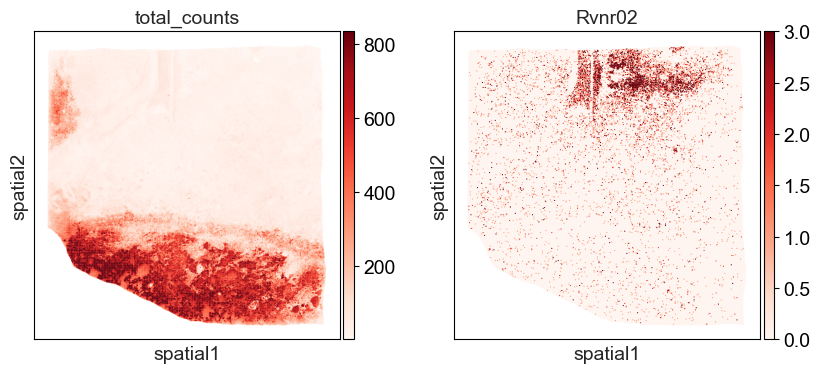

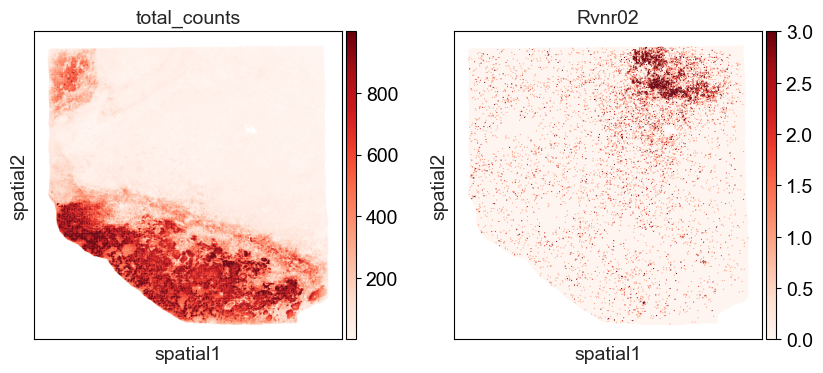

In [27]:
sc.pl.spatial(c1, color=['total_counts', 'Rvnr02'], spot_size=80, vmax='p99', cmap='Reds')
sc.pl.spatial(d5, color=['total_counts', 'Rvnr02'], spot_size=80, vmax='p99', cmap='Reds')

In [28]:
tissue_n = sc.concat([c1, d5], join='outer')

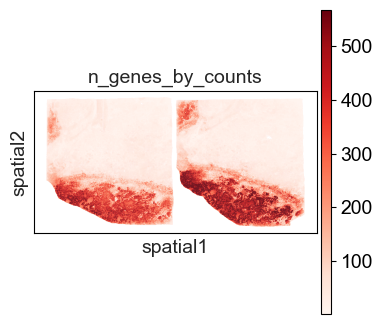

In [29]:
tissue_n.obs[['x', 'y']] = tissue_n.obsm['spatial'].copy()
reloc(tissue_n, arrange='v')
sc.pl.spatial(tissue_n, color=['n_genes_by_counts'], cmap='Reds', vmax='p99', ncols=1, spot_size=80)

In [31]:
tissue_n.write('tissue_n_raw.h5ad')

In [32]:
tbgenes = [x for x in tissue_n.var_names if x.startswith('Rv') or x.startswith('RV')]
tissue_n.obs['tb_counts'] = tissue_n[:, tbgenes].X.sum(axis=1).A[:,0]

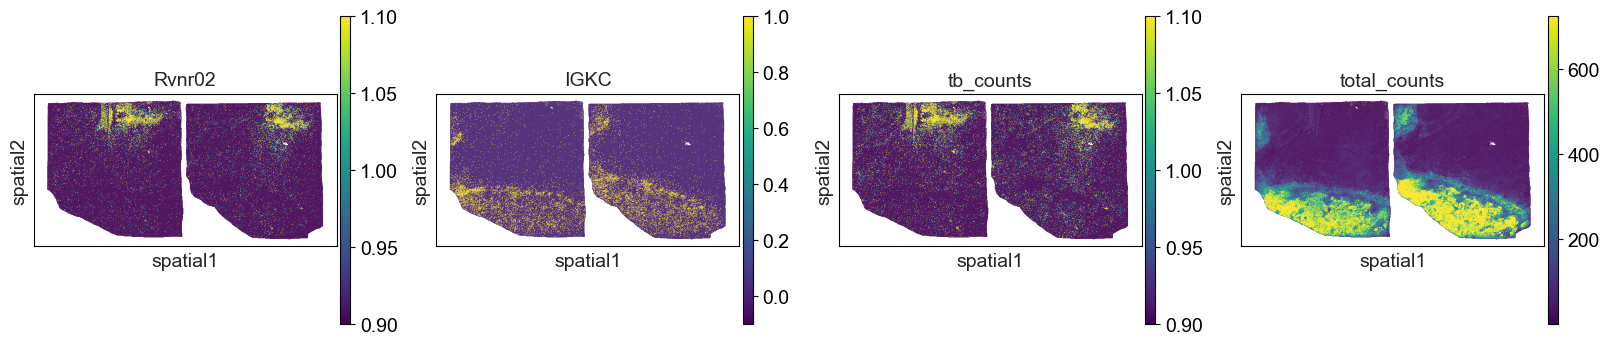

In [33]:
sc.pl.spatial(tissue_n, spot_size=80, color=['Rvnr02', 'IGKC', 'tb_counts', 'total_counts' ], vmax='p95', vmin=1, cmap='viridis', save='tissue_n_tb_count.pdf')

/home/lee/miniconda3/envs/rapids/lib/python3.10/site-packages/scipy/sparse/_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


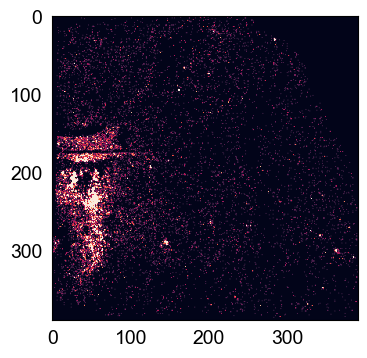

In [34]:
gene2im(tissue_n[tissue_n.obs['sample']=='H01203C1'], tbgenes, bin_size=50, save='H01203C1_bin50.tif')

/home/lee/miniconda3/envs/rapids/lib/python3.10/site-packages/scipy/sparse/_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


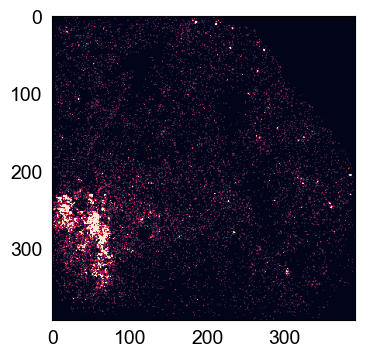

In [35]:
gene2im(tissue_n[tissue_n.obs['sample']=='H01203D5'], tbgenes, bin_size=50, save='H01203D5_bin50.tif')

# tissu C

In [36]:
f1 = gem2adata('gem/H01203F1.lasso.bin1.tissue.gem.gz', binsize=50)
f3 = gem2adata('gem/G01138F3.lasso.bin1.tissue.gem.gz', binsize=50)

In [37]:
f3.obsm['spatial'] = f3.obsm['spatial'][:, [1,0]]
f3.obsm['spatial'][:, 1] = -f3.obsm['spatial'][:, 1]

In [38]:
f1.obs['sample'] = 'H012030F1'
f1.obs_names = ['H012030F1@' + x for x in f1.obs_names]
f3.obs['sample'] = 'G01138F3'
f3.obs_names = ['G01138F3@' + x for x in f3.obs_names]


In [39]:
tissue_c = sc.concat([f1, f3], join='outer')

In [40]:
tissue_c = sc_qc(tissue_c, sc_filter=False)

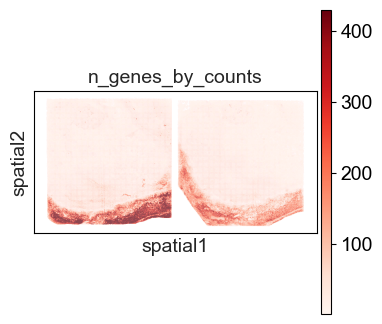

In [41]:
tissue_c.obs[['x', 'y']] = tissue_c.obsm['spatial'].copy()
reloc(tissue_c, arrange='v')
sc.pl.spatial(tissue_c, color=['n_genes_by_counts'], cmap='Reds', vmax='p99', ncols=1, spot_size=60)

In [43]:
tissue_c.write('tissue_c_bin50_raw.h5ad')

In [44]:
tbgenes = [x for x in tissue_c.var_names if x.startswith('Rv') or x.startswith('RV')]
tissue_c.obs['tb_counts'] = tissue_c[:, tbgenes].X.sum(axis=1).A[:,0]

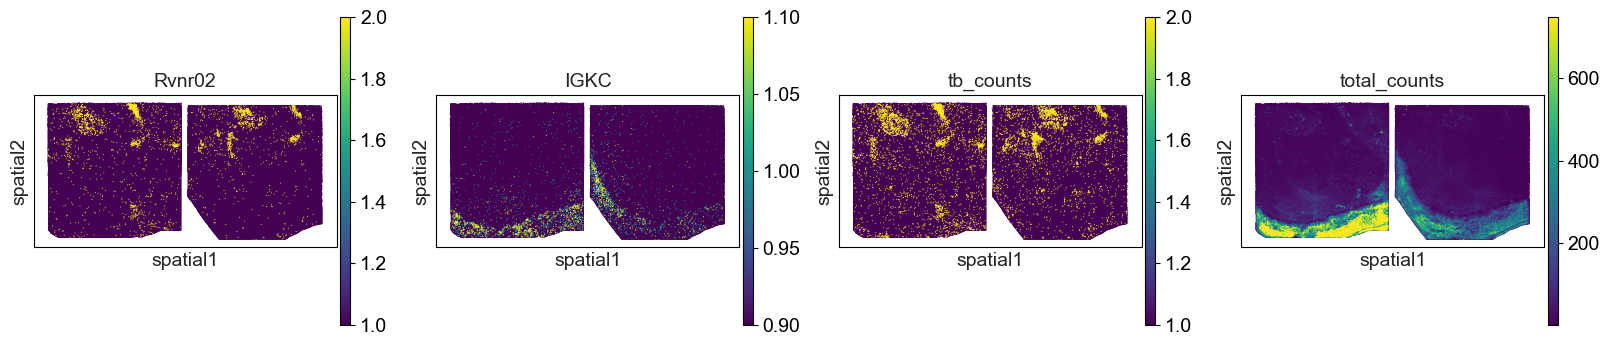

In [46]:
sc.pl.spatial(tissue_c, spot_size=150, color=['Rvnr02', 'IGKC', 'tb_counts', 'total_counts' ], vmax='p99', vmin=1, cmap='viridis', save='tissue_c_tb_count.pdf')

/home/lee/miniconda3/envs/rapids/lib/python3.10/site-packages/scipy/sparse/_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


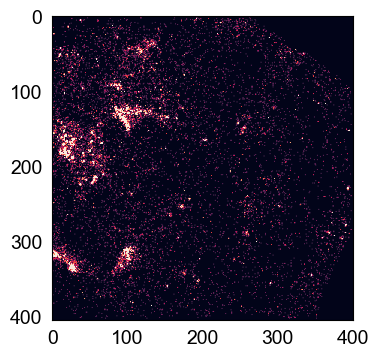

In [47]:
gene2im(tissue_c[tissue_c.obs['sample']=='H012030F1'], tbgenes, bin_size=50, save='H012030F1_bin50.tif')

/home/lee/miniconda3/envs/rapids/lib/python3.10/site-packages/scipy/sparse/_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


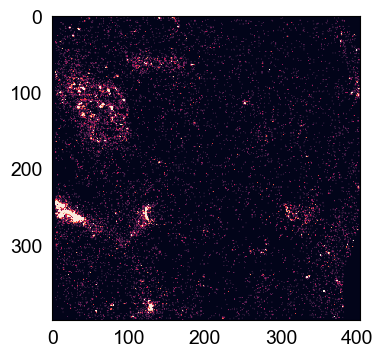

In [48]:
gene2im(tissue_c[tissue_c.obs['sample']=='G01138F3'], tbgenes, bin_size=50, save='G01138F3_bin50.tif')

In [49]:
adata = sc.concat([tissue_c, tissue_o, tissue_n], join='outer')

In [50]:
loc = adata.obsm['spatial'].copy()

In [53]:
adata.obs['sample'].unique()

['H012030F1', 'G01138F3', 'H01203A3', 'H01203C3', 'H01203C1', 'H01203D5']
Categories (6, object): ['G01138F3', 'H01203A3', 'H01203C1', 'H01203C3', 'H01203D5', 'H012030F1']

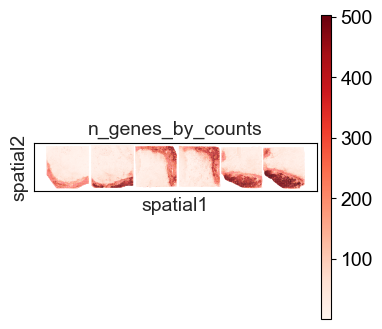

In [64]:
reloc(adata, arrange='h', cat=['H012030F1', 'G01138F3', 'H01203A3', 'H01203C3', 'H01203C1', 'H01203D5'])
sc.pl.spatial(adata, color=['n_genes_by_counts'], cmap='Reds', vmax='p99', ncols=1, spot_size=60)

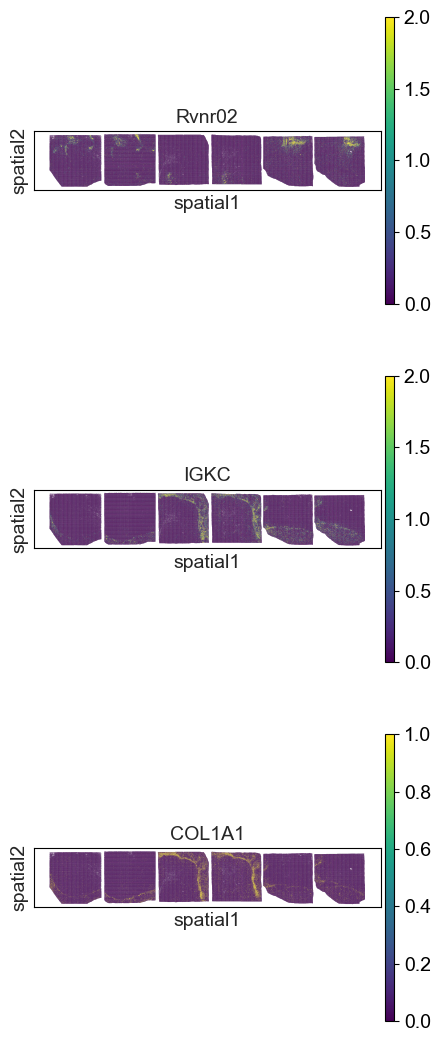

In [57]:
sc.pl.spatial(adata, color=['Rvnr02', 'IGKC', 'COL1A1'], cmap='viridis', vmax='p99', ncols=1, spot_size=60, save='markers.pdf')

In [58]:
adata.write('human_tb_raw.adata')

In [59]:
adata.layers['counts'] = adata.X.copy()

In [60]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

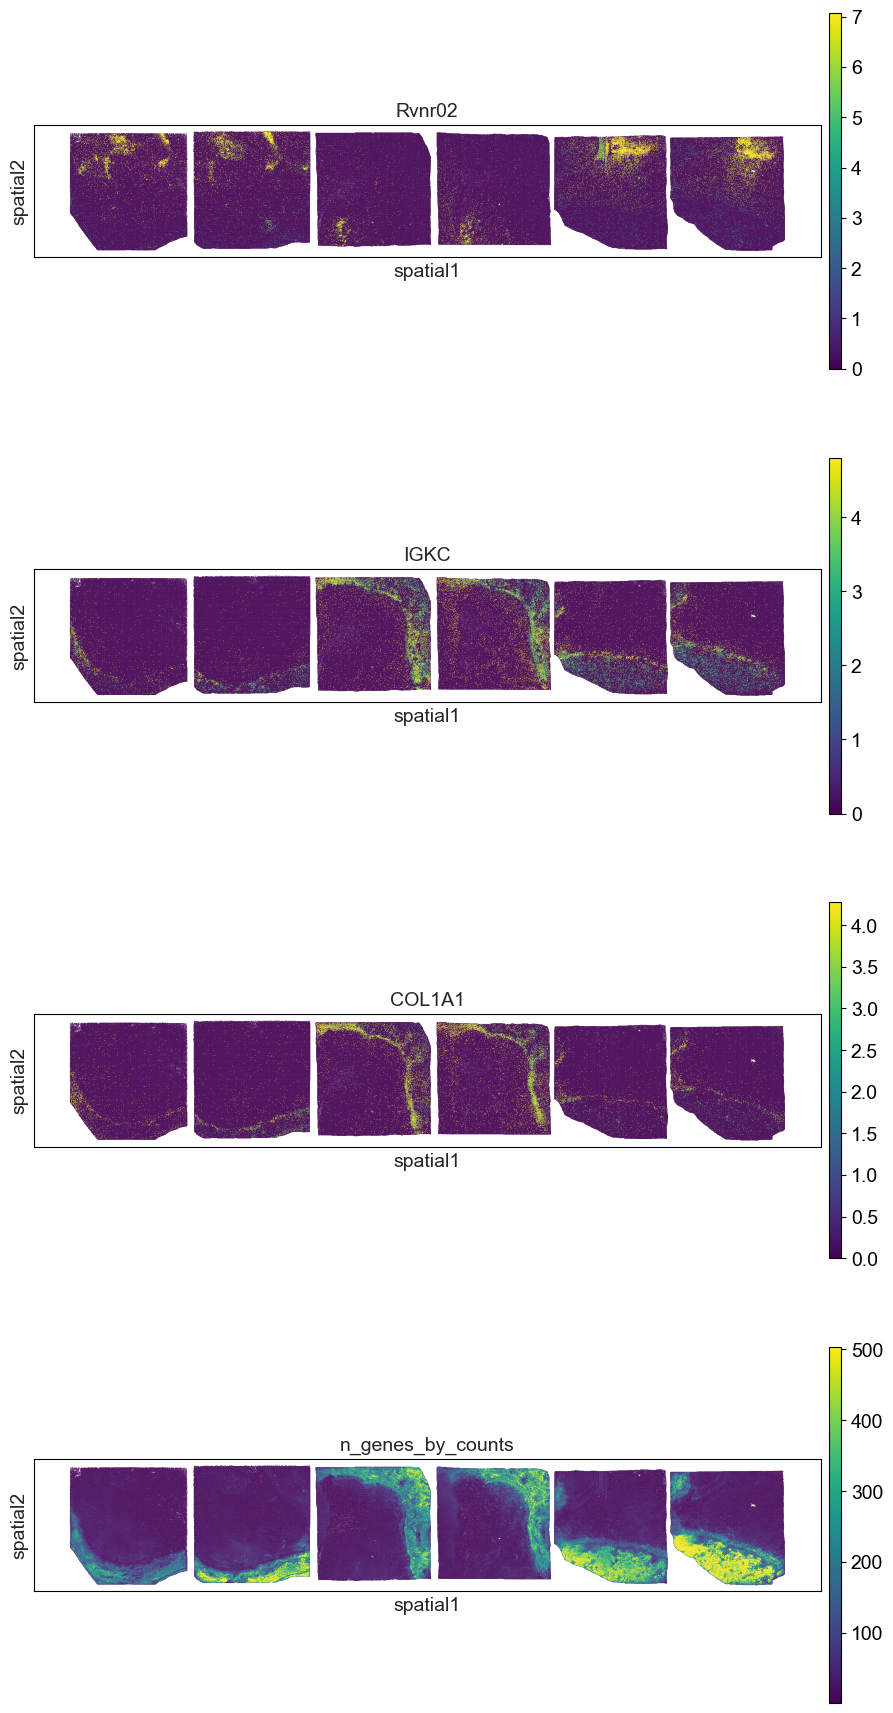

In [66]:
with rc_context(rc={'figure.figsize': (10, 5)}):
    sc.pl.spatial(adata, color=['Rvnr02', 'IGKC', 'COL1A1', 'n_genes_by_counts'], cmap='viridis', vmax='p99', ncols=1, spot_size=80, save='markers.pdf')

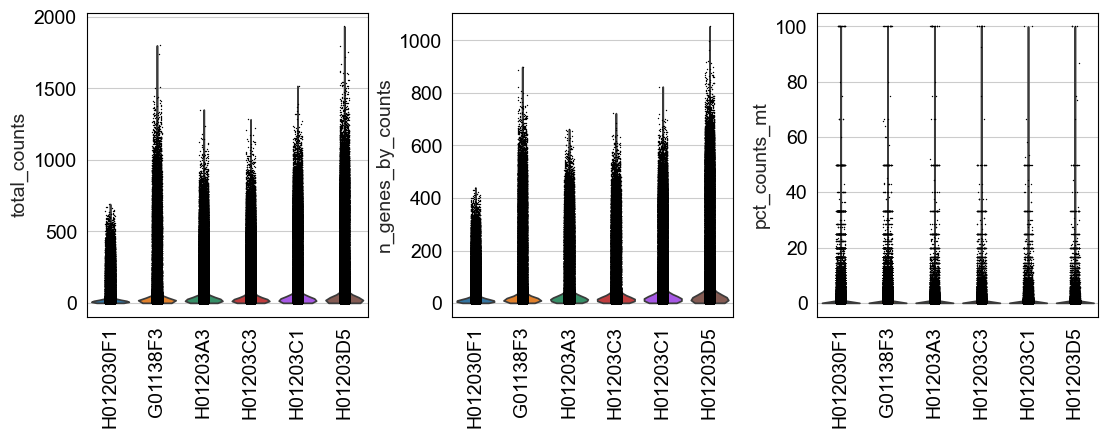

In [70]:
sc.pl.violin(adata, groupby='sample', keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],rotation=90, sc)

In [68]:
sc.pl.

x      y     sample  n_genes_by_counts  \
H012030F1@DNB_0_3250           0   3250  H012030F1                  1   
H012030F1@DNB_10000_10000  10000  10000  H012030F1                  6   
H012030F1@DNB_10000_10050  10000  10050  H012030F1                 10   
H012030F1@DNB_10000_10100  10000  10100  H012030F1                 11   
H012030F1@DNB_10000_10150  10000  10150  H012030F1                  9   
...                          ...    ...        ...                ...   
H01203D5@DNB_9950_9750      9950   9750   H01203D5                  3   
H01203D5@DNB_9950_9800      9950   9800   H01203D5                  2   
H01203D5@DNB_9950_9850      9950   9850   H01203D5                  1   
H01203D5@DNB_9950_9900      9950   9900   H01203D5                  8   
H01203D5@DNB_9950_9950      9950   9950   H01203D5                 19   

                           total_counts  total_counts_mt  pct_counts_mt  \
H012030F1@DNB_0_3250                  1                0            0.0   
H012030F1@DNB_10000_10000             7                0            0.0   
H012030F1@DNB_10000_10050            10                0            0.0   
H012030F1@DNB_10000_10100            13                0            0.0   
H012030F1@DNB_10000_10150            10                0            0.0   
...                                 ...              ...            ...   
H01203D5@DNB_9950_9750                3                0            0.0   
H01203D5@DNB_9950_9800                2                0            0.0   
H01203D5@DNB_9950_9850                1                0            0.0   
H01203D5@DNB_9950_9900               12                0            0.0   
H01203D5@DNB_9950_9950               25                0            0.0   

                           total_counts_rp  pct_counts_rp  tb_counts  
H012030F1@DNB_0_3250                     0            0.0          0  
H012030F1@DNB_10000_10000                0            0.0          0  
H012030F1@DNB_10000_10050                0            0.0          0  
H012030F1@DNB_10000_10100                0            0.0          0  
H012030F1@DNB_10000_10150                0            0.0          0  
...                                    ...            ...        ...  
H01203D5@DNB_9950_9750                   0            0.0          0  
H01203D5@DNB_9950_9800                   0            0.0          0  
H01203D5@DNB_9950_9850                   0            0.0          0  
H01203D5@DNB_9950_9900                   0            0.0          0  
H01203D5@DNB_9950_9950                   0            0.0          0  

[866305 rows x 10 columns]

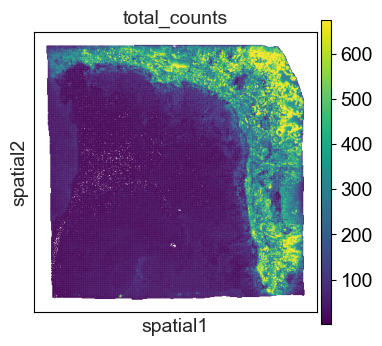

In [72]:
sc.pl.spatial(A3, color=['total_counts'], cmap='viridis', vmax='p99', ncols=1, spot_size=80, save='a3.pdf')

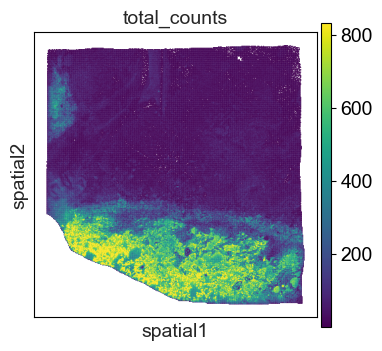

In [76]:
sc.pl.spatial(c1, color=['total_counts'], cmap='viridis', vmax='p99', ncols=1, spot_size=80, save='c1.pdf')

KeyError: 'Could not find key total_counts in .var_names or .obs.columns.'

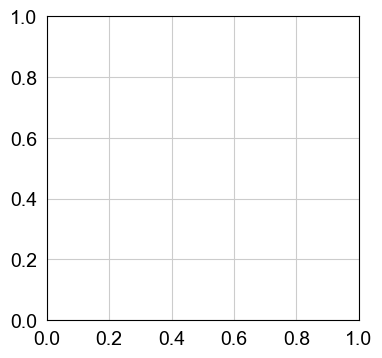

In [74]:
sc.pl.spatial(f3, color=['total_counts'], cmap='viridis', vmax='p99', ncols=1, spot_size=80, save='f3.pdf')

In [75]:
f3

AnnData object with n_obs × n_vars = 155918 × 41474
    obs: 'x', 'y', 'sample'
    obsm: 'spatial'